# Timeseries Forecasting of Cryptocurrency Prices

In this exploration, I make an attempt to train recurrent neural networks to predict the price of cryptocurrencies such as bitcoin.

## Importing Libraries and Reading in the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/ETH USD Historical Data.csv')
data.head()

Date     Price      Open      High       Low     Vol.  Change %
0  Jan 11, 2018  1,229.10  1,245.90  1,331.80  1,109.80  364.76K     -1.51
1  Jan 10, 2018  1,248.00  1,285.70  1,381.90  1,203.20  380.43K     -2.78
2  Jan 09, 2018  1,283.70  1,129.40  1,299.00  1,119.10  296.90K     13.67
3  Jan 08, 2018  1,129.30  1,115.90  1,225.00    968.12  439.43K      1.21
4  Jan 07, 2018  1,115.80  1,004.30  1,116.00    999.50  199.83K     11.10

In [3]:
data.tail()

Date             Price         Open                 High  \
670  Mar 12, 2016             12.92        11.95                13.45   
671  Mar 11, 2016             11.95        11.75                11.95   
672  Mar 10, 2016             11.75        11.20                11.85   
673           NaN               NaN          NaN                  NaN   
674           NaN  Highest:1,381.90  Lowest:5.86  Difference:1,376.04   

                Low                Vol.  Change %  
670           11.95               0.24K      8.12  
671           11.75               0.05K      1.70  
672           11.07               0.00K      4.91  
673             NaN                 NaN       NaN  
674  Average:141.45  Change %:10,874.11       NaN

In [4]:
data.dropna(axis=0, inplace=True)
data = data.iloc[::-1]

In [5]:
from pandas import datetime
data['Date'] = data['Date'].apply(lambda date: pd.to_datetime(date))

In [6]:
import locale
from locale import *
locale.setlocale(locale.LC_NUMERIC, '')
data['Price'] = data['Price'].apply(lambda x: atof(x))

In [7]:
data['Open'] = data['Open'].apply(lambda x: atof(x))
data['High'] = data['High'].apply(lambda x: atof(x))
data['Low'] = data['Low'].apply(lambda x: atof(x))

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673 entries, 672 to 0
Data columns (total 7 columns):
Date        673 non-null datetime64[ns]
Price       673 non-null float64
Open        673 non-null float64
High        673 non-null float64
Low         673 non-null float64
Vol.        673 non-null object
Change %    673 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 42.1+ KB


## Visualizing prices for the whole dataset

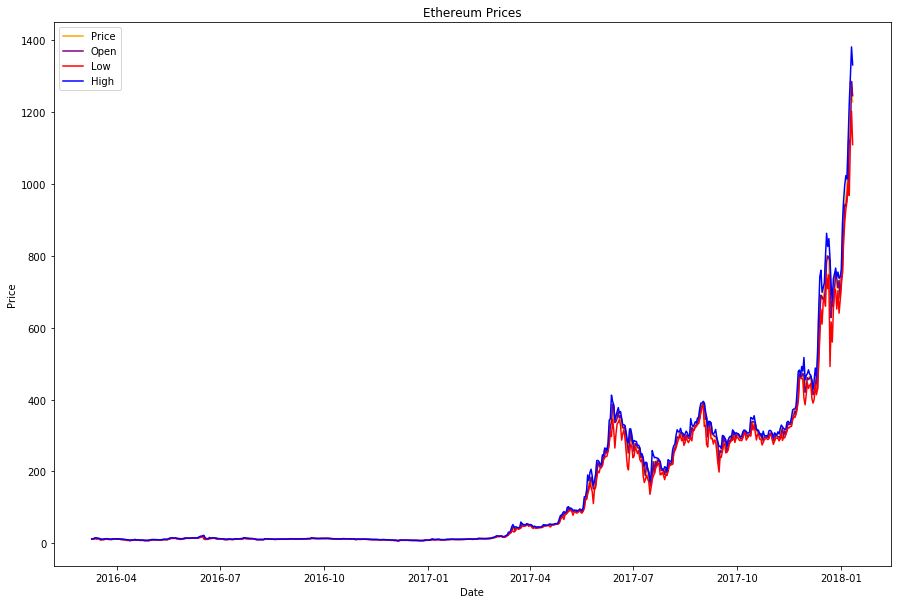

In [9]:
plt.plot(data['Date'], data['Price'], color = 'orange')
plt.plot(data['Date'], data['Open'], color='purple')
plt.plot(data['Date'], data['Low'], color='red')
plt.plot(data['Date'], data['High'], color='blue')
plt.title('Ethereum Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.savefig('./plots/historical_prices.png')

## Using TensorFlow to Train RNNs

In [10]:
import tensorflow as tf

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [11]:
data = data.set_index('Date')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 2016-03-10 to 2018-01-11
Data columns (total 6 columns):
Price       673 non-null float64
Open        673 non-null float64
High        673 non-null float64
Low         673 non-null float64
Vol.        673 non-null object
Change %    673 non-null float64
dtypes: float64(5), object(1)
memory usage: 36.8+ KB


### Scaling the Data
In order to train a neural network on this data, it is a good idea to scale it first.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
price_data_scaled = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

### Creating a Dataset with Features

In [16]:
def create_dataset(timeseries, n_inputs=30):
    
    features = []
    targets = []
    
    for i in range(len(timeseries) - n_inputs):
        
        start = i
        end = start + n_inputs
        
        x = timeseries[start:end]
        y = timeseries[end]
        
        features.append(x)
        targets.append(y)
    
    return np.array(features), np.array(targets)

In [17]:
X, y = create_dataset(price_data_scaled, n_inputs=14)

In [18]:
X.shape

(659, 14, 1)

In [19]:
percent_training = 0.75
num_samples = X.shape[0]
num_train = int(percent_training * num_samples)

X_train, y_train = X[:num_train], y[:num_train]
X_test, y_test = X[num_train:], y[num_train:]

## Training the RNN Model

In [20]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

num_inputs = 14

model = Sequential()
model.add(LSTM(100, input_shape=(num_inputs, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

Using TensorFlow backend.


In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          batch_size=1, epochs=100, callbacks=[early_stopping])

Train on 494 samples, validate on 165 samples
Epoch 1/100
494/494 [==============================] - 9s 18ms/step - loss: 4.6455e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0034 - val_mean_absolute_error: 0.0362
Epoch 2/100
494/494 [==============================] - 7s 14ms/step - loss: 1.8523e-04 - mean_absolute_error: 0.0074 - val_loss: 0.0018 - val_mean_absolute_error: 0.0282
Epoch 3/100
494/494 [==============================] - 7s 15ms/step - loss: 1.4952e-04 - mean_absolute_error: 0.0066 - val_loss: 0.0029 - val_mean_absolute_error: 0.0400
Epoch 4/100
494/494 [==============================] - 7s 15ms/step - loss: 1.4074e-04 - mean_absolute_error: 0.0064 - val_loss: 0.0011 - val_mean_absolute_error: 0.0202
Epoch 5/100
494/494 [==============================] - 8s 16ms/step - loss: 1.3521e-04 - mean_absolute_error: 0.0059 - val_loss: 9.8678e-04 - val_mean_absolute_error: 0.0218
Epoch 6/100
494/494 [==============================] - 8s 15ms/step - loss: 1.1855e-04 - mean_absolu

In [22]:
model.save('./models/ethereum_model.h5')

### Comparing Generated Predictions with Prices in Testing Set

In [23]:
pred = model.predict(X_test)

In [24]:
pred.shape

(165, 1)

In [25]:
results = scaler.inverse_transform(pred)

In [26]:
num_samples = pred.shape[0]
test_data_price = data.iloc[-num_samples:]['Price']

In [27]:
test_data_price_pred = pd.DataFrame({'Date': test_data_price.index, 
                                     'Price': test_data_price.values, 
                                     'Prediction': results[:, 0]})

In [28]:
test_data_price_pred

Date   Prediction    Price
0   2017-07-31   182.731506   200.81
1   2017-08-01   185.096420   225.97
2   2017-08-02   201.064392   218.00
3   2017-08-03   205.087219   224.79
4   2017-08-04   210.809387   220.73
5   2017-08-05   210.858459   253.87
6   2017-08-06   229.164627   264.29
7   2017-08-07   243.774765   269.51
8   2017-08-08   253.452896   295.83
9   2017-08-09   272.520813   293.99
10  2017-08-10   279.739044   295.97
11  2017-08-11   283.094788   308.81
12  2017-08-12   290.660522   307.22
13  2017-08-13   292.070190   296.64
14  2017-08-14   285.623016   298.22
15  2017-08-15   282.405396   286.00
16  2017-08-16   273.058746   301.34
17  2017-08-17   277.141846   299.00
18  2017-08-18   278.014923   292.00
19  2017-08-19   274.917999   292.78
20  2017-08-20   274.008392   298.37
21  2017-08-21   276.930664   322.24
22  2017-08-22   292.363953   312.54
23  2017-08-23   294.483154   316.50
24  2017-08-24   297.732635   325.62
25  2017-08-25   304.066681   328.70
26  2017-08-26   308.345093   332.72
27  2017-08-27   312.206543   348.01
28  2017-08-28   322.387817   347.09
29  2017-08-29   326.295135   372.00
..         ...          ...      ...
135 2017-12-13   544.251831   690.69
136 2017-12-14   618.863953   686.51
137 2017-12-15   649.449646   678.29
138 2017-12-16   655.387939   683.25
139 2017-12-17   655.931458   708.78
140 2017-12-18   665.658630   783.99
141 2017-12-19   709.305359   799.98
142 2017-12-20   734.733398   794.99
143 2017-12-21   741.956055   786.97
144 2017-12-22   738.992126   628.19
145 2017-12-23   643.942688   672.59
146 2017-12-24   626.166687   659.89
147 2017-12-25   607.459045   709.81
148 2017-12-26   629.065918   749.80
149 2017-12-27   663.574707   736.45
150 2017-12-28   673.816223   711.42
151 2017-12-29   666.177002   731.52
152 2017-12-30   674.899719   682.22
153 2017-12-31   649.287720   736.77
154 2018-01-01   669.289185   752.46
155 2018-01-02   685.545166   858.78
156 2018-01-03   754.617981   942.01
157 2018-01-04   832.096069   940.00
158 2018-01-05   863.957886   962.77
159 2018-01-06   890.855774  1004.30
160 2018-01-07   923.055725  1115.80
161 2018-01-08   996.926025  1129.30
162 2018-01-09  1030.285767  1283.70
163 2018-01-10  1130.876953  1248.00
164 2018-01-11  1144.776978  1229.10

[165 rows x 3 columns]

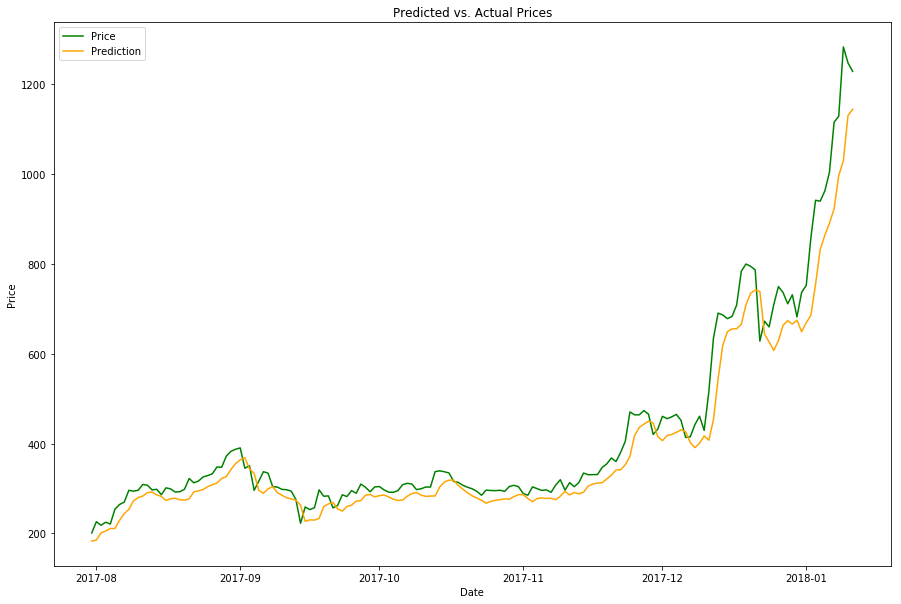

In [31]:
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Price'], color='green')
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Prediction'], color='orange')
plt.legend()
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.savefig('./plots/predictions.png')